# Modeling

## Import basic packages and os

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
import os

## Importing train-test split data

In [2]:
%store -r X_train X_test X_val y_train y_test y_val

In [3]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((238352, 9), (29794, 9), (29794, 9), (238352,), (29794,), (29794,))

In [4]:
X_train = X_train.copy()
X_test = X_test.copy()
X_val = X_val.copy()
y_train = y_train.copy()
y_test = y_test.copy()
y_val = y_val.copy()

We will try out a few different regression ML models to see which performs the best.

These will include:

- Linear Regression
- Random Forest Regression
- Gradient Boosting

## Linear Regression

In [5]:
# Importing Linear Regrssion model and metrics
from sklearn.linear_model import LinearRegression

As seen from the EDA, the flight class would be the best feature to consider with the others when making a linear regression model.

**Training and evaluation metrics for the LR model with training data**

In [6]:
# Initializing the model
LR_model = LinearRegression()

# List of the X_train columns
columns = X_train.columns

# Empty list of the combined features with r^2 scores
new_features = []
r2_scores = []
r2_val_scores = []

for col in columns:
    # Iterate through the column names and multiply with the flight class feature
    col_name = 'class*' + col
    # Subsetting the X_train, test, val with the new features
    X_train[col_name] = X_train['class']*X_train[col]
    X_test[col_name] = X_test['class']*X_test[col]
    X_val[col_name] = X_val['class']*X_val[col]
    # Fit and predict the LR model with each new X subset 
    LR_model.fit(X_train, y_train)
    y_pred = LR_model.predict(X_test)
    y_val_pred = LR_model.predict(X_val)
    r2 = round(r2_score(y_test, y_pred),3)
    r2_val = round(r2_score(y_val, y_val_pred),3)

    # Appending the lists
    new_features.append(col_name)
    r2_scores.append(r2)
    r2_val_scores.append(r2_val)

lr_cols_scores = pd.DataFrame({'Features':new_features,
                               'R\u00b2':r2_scores,
                               'validation R\u00b2':r2_val_scores})

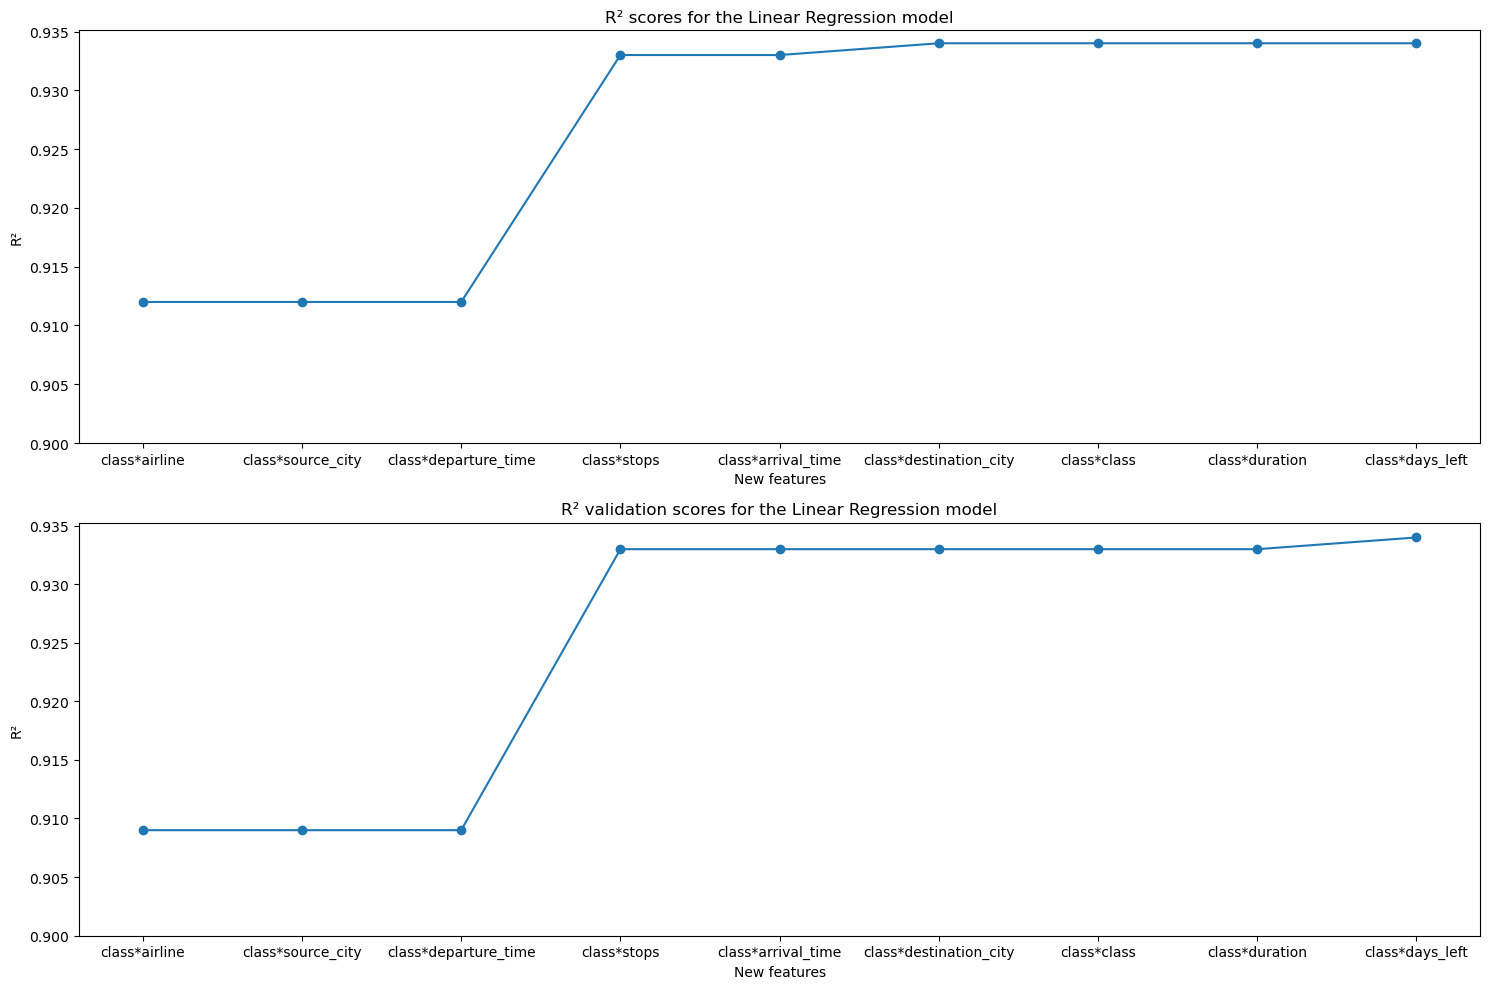

In [7]:
# Plot the scores
fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].plot(new_features, r2_scores, marker='o', linestyle='-')
ax[0].set_ylim(ymin=0.9)
ax[0].set_ylabel('R\u00b2')
ax[0].set_xlabel('New features')
ax[0].set_title('R\u00b2 scores for the Linear Regression model')

ax[1].plot(new_features, r2_val_scores, marker='o', linestyle='-')
ax[1].set_ylim(ymin=0.9)
ax[1].set_ylabel('R\u00b2')
ax[1].set_xlabel('New features')
ax[1].set_title('R\u00b2 validation scores for the Linear Regression model')

best_feat = lr_cols_scores['Features'].loc[lr_cols_scores['R\u00b2'].idxmax()]
best_feat_val = lr_cols_scores['Features'].loc[lr_cols_scores['validation R\u00b2'].idxmax()]

plt.tight_layout()
plt.show()

In [8]:
print(f'Best feature: {best_feat}. R\u00b2: {max(r2_scores)}')
print(f'Best feature (validation): {best_feat_val}. R\u00b2: {max(r2_val_scores)}')

Best feature: class*destination_city. R²: 0.934
Best feature (validation): class*days_left. R²: 0.934


The best $R^2$ for both the model using the training set and the model using the validation set come out at 0.934.

Training set considers the **destination city** to be the best feature to consider when modeling around the flight class, but the validation data suggests that **days left** is as important.

These models could be overfitting with having such high $R^2$ scores.

## Lasso

In [9]:
# Importing RF Reg model
from sklearn.linear_model import Lasso

In [10]:
# Initializing the model
lasso_model = Lasso(random_state=42)

# Making parameter grid
param_grid_ls = {'alpha':[0.001,0.01,0.1,1,10,100]}

grid_search_ls = GridSearchCV(lasso_model, param_grid_ls, cv=5, scoring='r2')

# Fitting the training data
grid_search_ls.fit(X_train, y_train)

# Best estimator and parameters
best_lasso = grid_search_ls.best_estimator_
best_lasso_params = grid_search_ls.best_params_

# Predicitng
y_pred_ls = best_lasso.predict(X_test)
y_pred_ls_val = best_lasso.predict(X_val)

# R^2 scores
r2_ls = round(r2_score(y_test, y_pred_ls),3)
r2_ls_val = round(r2_score(y_val, y_pred_ls_val),3)

# RMSE values
rmse_ls = np.sqrt(mean_squared_error(y_test, y_pred_ls))
rmse_ls_val = np.sqrt(mean_squared_error(y_val, y_pred_ls_val))

C:\Users\adre9\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.592e+10, tolerance: 9.850e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\adre9\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+10, tolerance: 9.882e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\adre9\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e+10, toleranc

In [11]:
print(f'Best Lasso model parameter: {best_lasso_params}')

Best Lasso model parameter: {'alpha': 0.001}


In [12]:
print(f'Lasso Regression model metrics with training data')
print(f'R\u00b2: {round(r2_ls,3)}')
print(f'RMSE: {rmse_ls}')

Lasso Regression model metrics with training data
R²: 0.934
RMSE: 5812.902443008178


In [13]:
print(f'Lasso Regression model metrics with validation data')
print(f'R\u00b2: {round(r2_ls_val,3)}')
print(f'RMSE: {rmse_ls_val}')

Lasso Regression model metrics with validation data
R²: 0.934
RMSE: 5846.3878928413005


Lasso Regression model also seems like a good choice with both the training and validation data used to train it coming out with the same $R^2$ as 0.934.

## Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
# Initializing the model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fitting the model
gbr_model.fit(X_train, y_train)

# Making the predictions
y_pred_gbr = gbr_model.predict(X_test)
y_pred_gbr_val = gbr_model.predict(X_val)

# Evaluating the metrics
r2_gbr = r2_score(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr_val = r2_score(y_val, y_pred_gbr_val)
rmse_gbr_val = np.sqrt(mean_squared_error(y_val, y_pred_gbr_val))

In [17]:
print(f'Gradient Boosting Regressor model testing data metrics:')
print(f'R\u00b2: {round(r2_gbr,3)}')
print(f'RMSE: {rmse_gbr}')

Gradient Boosting Regressor model testing data metrics:
R²: 0.956
RMSE: 4761.828125983077


In [18]:
print(f'Gradient Boosting Regressor model validation data metrics:')
print(f'R\u00b2: {round(r2_gbr_val,3)}')
print(f'RMSE: {rmse_gbr_val}')

Gradient Boosting Regressor model validation data metrics:
R²: 0.955
RMSE: 4807.503164014306


## Final results

Gradient Boosting Regressor has the best R² of 0.956


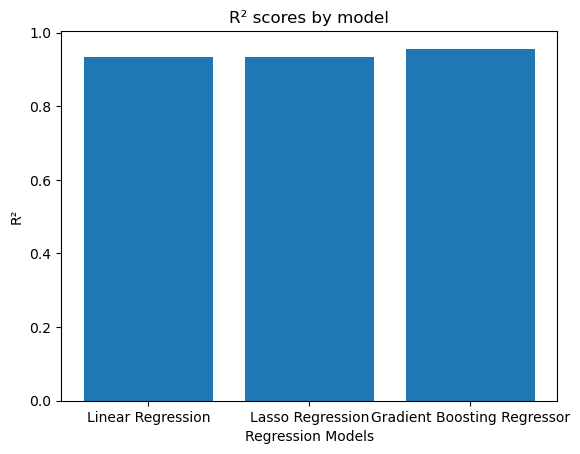

In [27]:
models = ['Linear Regression', 'Lasso Regression', 'Gradient Boosting Regressor']
r2_model_scores = [max(r2_scores), round(r2_ls,3), round(r2_gbr,3)]

r2_df = pd.DataFrame({'Models':models,'r2':r2_model_scores})
max_r2 = r2_df['r2'].idxmax()
best_model = r2_df['Models'].iloc[max_r2]

print(f'{best_model} has the best R\u00b2 of {max(r2_model_scores)}')

plt.bar(models, r2_model_scores)
plt.xlabel('Regression Models')
plt.ylabel('R\u00b2')
plt.title('R\u00b2 scores by model')
plt.show()

The gradient boosting regressor will be our model of choice.